<a href="https://colab.research.google.com/github/IntroductionToAICW/CW/blob/main/preprocessing/textPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [14]:
!pip install contractions
!pip install langdetect

In [15]:
import pandas as pd
import unicodedata
from bs4 import BeautifulSoup
import contractions
import re
import string
import nltk
import gensim

from nltk.corpus import twitter_samples 
nltk.download('twitter_samples')

from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet

import langdetect 
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load datatasets

You don't need to be connected to the drive to run the text preprocessing file, but you need it to store the output and to run the algorithms.

In [16]:
'''
for the purpose of the cw and to be able to run our code efficiently and fast we created an email address in order to store our data there
email: introtoaicw@gmail.com
pass : Intro2020
'''
from google.colab import drive

drive.mount('/content/drive')


In [18]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [19]:
negLabel = []
posLabel = []
for i in range(0, 5000):
  negLabel.append(0)
  posLabel.append(1)

In [20]:
labels = posLabel + negLabel

In [21]:
tempTweet = all_positive_tweets + all_negative_tweets

In [22]:
data = {'text':tempTweet, 'labels':labels} 

In [23]:
df = pd.DataFrame(data) 

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   labels  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [25]:
df

,text,labels
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1
...,...,...
9995,I wanna change my avi but uSanele :(,0
9996,MY PUPPY BROKE HER FOOT :(,0
9997,where's all the jaebum baby pictures :((,0
9998,But but Mr Ahmad Maslan cooks too :( https://t...,0


# Language distribution

In [26]:
df['lang'] = df["text"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

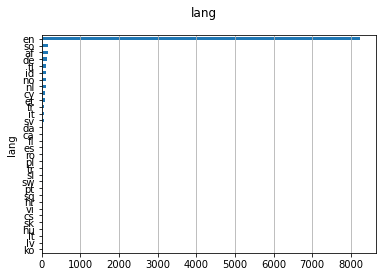

In [27]:
# we do this to make sure that we don't have any other language in our dataframe
import matplotlib.pyplot as plt

x = "lang"
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# Steps of text Preprocessing

## HTML tags removal

In [28]:
df["NoHTML_text"] = df["text"].map(lambda x: BeautifulSoup(x, "html.parser").get_text(separator = ' '))

## Non-ASCII and \n \r removal

In [29]:
df["ASCII_NoHTML_text"] = df["NoHTML_text"].str.encode(encoding = "ascii", errors="replace").str.decode(encoding = "utf-8", errors="replace")
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].map(lambda x: x.replace("\r", " "))
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].map(lambda x: x.replace("\n", " "))

## Contractions expanding (strictly needed before lowercasing, punctuation and stopwords removal)

In [30]:
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].map(lambda x:contractions.fix(x)) 

## Email addresses removal

In [31]:
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].map(lambda x: re.sub(r'\S+@\S+', ' ', x))

## Remove all the urls (www/http)

In [32]:
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].map(lambda x: re.sub(r'http\S+', ' ', x))
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].map(lambda x: re.sub(r'www\S+', ' ', x))

## Lowercasing

In [33]:
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].str.lower()

## Punctuation removal

In [34]:
list_punctuation= list(string.punctuation)

In [35]:
def remove_punctuations(text):
    text = str(text)
    for punctuation in list_punctuation:
        text = text.replace(punctuation, ' ')
    return text

In [36]:
df['ASCII_NoHTML_text'] = df['ASCII_NoHTML_text'].map(remove_punctuations)

## Digits removal

In [37]:
df["ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].str.replace('\d+', '')

## Lemmatisation and Pos


In [38]:
#return Wordnet's POS tag from NLTK's POS tag, for each to-be-lemmatised token 
#in order to provide it as parameter at Wordnet's lemmatizer() function so that it performs lemmatisation based on the correct POS tag format of the word in the emails
#we need the below mapping NLTK to Wordnet POS tag mapping function because lemmatizer() accepts the POS tag/ lemma basis parameter in Wordnet's format
def get_wordnet_pos(word):
    """Map NLTK's POS tag to first character Wordnet's lemmatize() accepts"""
    #pos_tag(): get the POS tag for a given single word/ token/ list of tokens ; it accepts only a list even in case of single word/ token, this is why we insert the word in brackets []
    #           returns also a list of two-size tuple of n (n=size of inserted list, n>=1) elements
    #           1st slot of the tuple has the inserted token of the ith element of inserted list, and the 2nd slot its POS tag  regardless of the inserted list size 
    #[0][1][0]: based on the above, with the first [0] we get inside the tuple of the returned/ output list
    #           with the [1] we get to the 2nd slot, thus the POS tag of the examined tuple
    #           with the final [0] we hold only the first character of the POS tag as brought from NLTK
    #.upper():  convert all lowercase characters in a string into uppercase characters; so that we are safe using only uppercase strings in mapping below
    tag = nltk.pos_tag([word])[0][1][0].upper()
    #mapping NLTK's first letter of POS tags (as brought from pos_tag() above) to the Wordnet POS tag format, which the POS tag format lemmatizer() accepts
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    #return the tag_dict's 'value' of tag (tag_dict's 'key')
    #wordnet.NOUN: optional parameter, a value to return ('n' POS tag in our case) if the specified 'key' (tag in our case) does not exist
    return tag_dict.get(tag, wordnet.NOUN)

#lemmatisation tries to convert a word to its meaningful base form/ lemma
lemmatizer = WordNetLemmatizer()
#we use list comprehension again here, however without 'if' conditional as it is not needed
#lemmatisation is performed on token so the token is provided as first parameter 
#and apart from the token itself we also provide as second parameter the (wordnet) POS tag of that token in order to provide for the lemmatizer function to learn the POS tag of the to-be-lemmatised token so the token is lemmatized correctly
df["Lemma_NoSal_ASCII_NoHTML_text"] = df["ASCII_NoHTML_text"].map(lambda x: " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(x)]))

## Stopwords removal

In [39]:
#a
#bring NLTK english stopwords
NLTK_english_stopwords = stopwords.words("english")
#bring Gensim (english) stopwords (converting them to a list from a frozenset)
#we need Gensim stopwords as well as it includes many missing from NLTK unimportant words (either, eg, etc, few, during and many others)
Gensim_stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
#spacy.load('en_core_web_md')

all_english_stopwords = NLTK_english_stopwords
#join together NLTK english and Gensim stopwords into a single list
all_english_stopwords.extend(Gensim_stopwords)
#change the list to a set in order to get the unique values, thus get rid of duplicate words existing in both NLTK and Gensim
all_english_stopwords = set(all_english_stopwords)
#change the set back to list holding all default NLTK and Gensim unique stopwords
all_english_stopwords = list(all_english_stopwords)
all_english_stopwords.sort()

#b
#user manually added english stopwords ('re' not included because it is already included in the below stopwords lists)
user_english_stopwords = []


#alphabet list in order to exclude single characters
english_alphabet = list(string.ascii_lowercase)
user_english_stopwords.extend(english_alphabet)
#bringing in a single list the [NLTK + Gensim] and [user defined stopwords + english alphabet]
all_english_stopwords.extend(user_english_stopwords)
#I want to hold negation stopwords as if bigrams are used (which according to an article are considered more powerful than unigrams)
#then the meaning of the tweet is conpletely different with their inclusion
#eg "not good" or "not bug" are different from "good", "bug" thus could also be categorised differently
#If unigrams are used then maybe I think I should remove them; will decide on a later phase according to results
negation_stopwords = ["no", "not"]
all_english_stopwords = [word for word in all_english_stopwords if word not in negation_stopwords]

#change the list to a set in order to get the unique values
all_english_stopwords = set(all_english_stopwords)
#change the set back to list holding all final stopwords
all_english_stopwords = list(all_english_stopwords)
all_english_stopwords.sort()

df["NoSW_Lemma_NoSal_ASCII_NoHTML_text"] = df["Lemma_NoSal_ASCII_NoHTML_text"].map(lambda x: " ".join([word for word in word_tokenize(x) if word not in (all_english_stopwords)]))

## Stemming

decide to not use stemming after analysis

In [40]:
# stemmer = LancasterStemmer()
# df['Stem_NoSW_Lemma_NoSal_ASCII_NoHTML_text'] = df['NoSW_Lemma_NoSal_ASCII_NoHTML_text'].map(lambda x: " ".join([stemmer.stem(word) for word in word_tokenize(x)]))

## Hold only valid preprocessed emails

In [41]:
valid_df = df.loc[df["NoSW_Lemma_NoSal_ASCII_NoHTML_text"].map(lambda x: len(x)!=0),].reset_index(drop=True)

In [42]:
valid_df["afterProcess"] = valid_df["NoSW_Lemma_NoSal_ASCII_NoHTML_text"]
valid_df['labels'] = df['labels']

## Save file in a pickle

In [43]:
valid_df.to_pickle("/content/drive/My Drive/dataset/valid_df.pkl")

FileNotFoundError: ignored

In [ ]:
valid_df["afterProcess"]